# CASA 002

## Part 1

### I Topology

#### Preparation

In [1]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

In [2]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

##### Station file

In [3]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           529 non-null    object  
 1   name         529 non-null    object  
 2   nlc_id       518 non-null    object  
 3   lines        529 non-null    object  
 4   cartography  529 non-null    object  
 5   altmodeid    16 non-null     object  
 6   alt_id       337 non-null    object  
 7   altmodeid2   2 non-null      object  
 8   zone         529 non-null    object  
 9   geometry     529 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 41.5+ KB


##### Clean station names

In [4]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

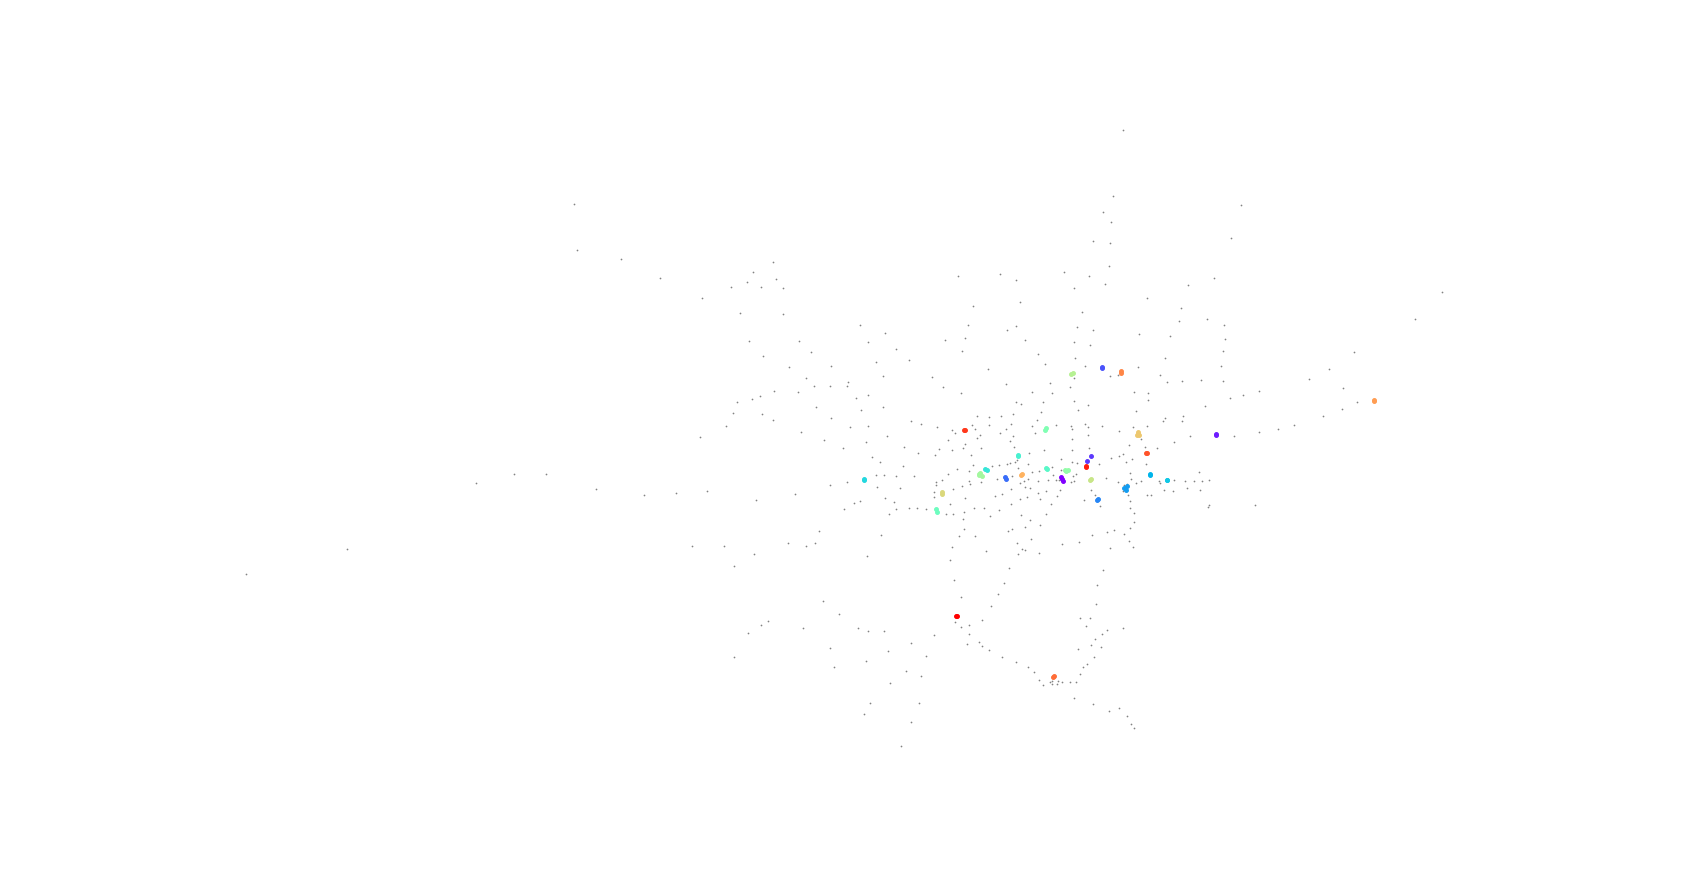

In [5]:
## we will plot all the stations with multiple points to check there are no errors
fig, ax = plt.subplots(figsize = (30,30))
ax.set_aspect("equal")
ax.axis('off')
ax.margins(0.2)
color = iter(cm.rainbow(np.linspace(0, 1, 29)))
stations.plot(ax=ax, color='grey', markersize=0.5)
for i, group in stations.groupby('name'):
    if len(group)>1:
        group.plot(ax=ax, color = next(color), markersize=15)
plt.show()

##### Change position of station to mean of all station with the same name

In [6]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [7]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

<AxesSubplot:>

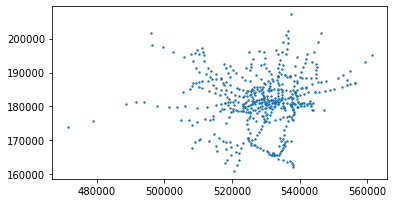

In [8]:
#check plot to make sure there are no errors
stations.plot(markersize=2)

##### Lines file

In [9]:
lines.head()

,id,lines,geometry
0,LeaValleyLine1,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534726.021 182339.910, 534747.550 ..."
1,LeaValleyLine2,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534826.495 183293.130, 534820.978 ..."
2,LeaValleyLine3,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534783.192 184262.624, 534785.835 ..."
3,LeaValleyLine4,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534530.346 185136.490, 534525.951 ..."
4,LeaValleyLine5,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (533996.588 186186.930, 533979.709 ..."


<AxesSubplot:>

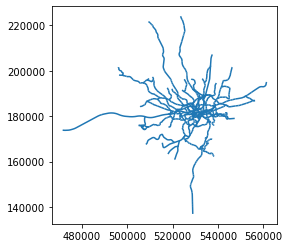

In [10]:
lines.plot()

##### Get all line names

In [11]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Circle',
 'Bakerloo',
 'Victoria',
 'District',
 'Thameslink 6tph line',
 'Northern',
 'Tramlink',
 'Metropolitan',
 'Central',
 'Jubilee',
 'Waterloo & City',
 'Emirates Air Line',
 'Piccadilly',
 'Crossrail 2',
 'Crossrail',
 'TfL Rail',
 'Hammersmith & City',
 'London Overground',
 'DLR',
 'East London']

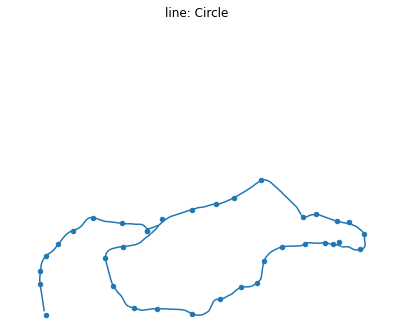

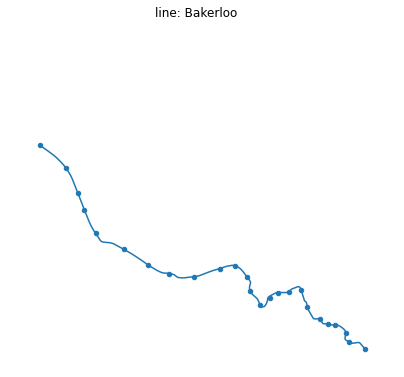

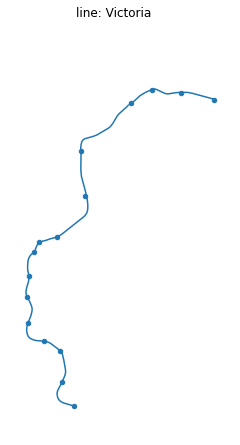

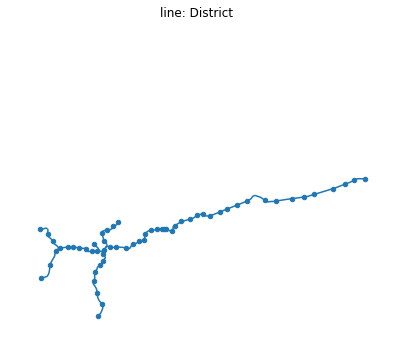

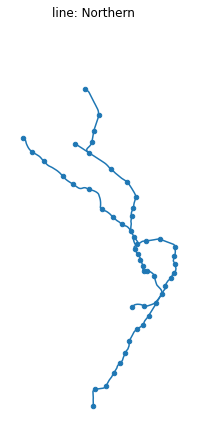

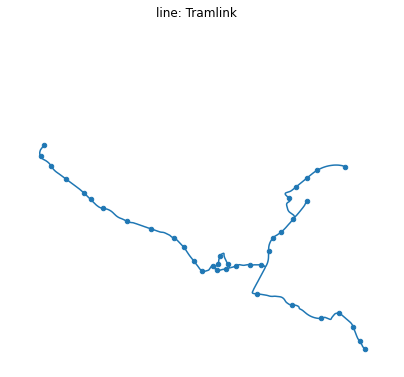

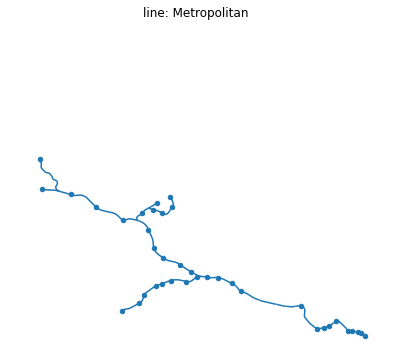

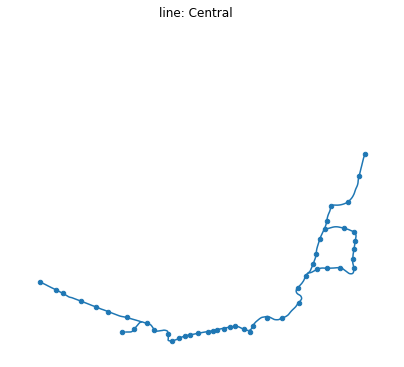

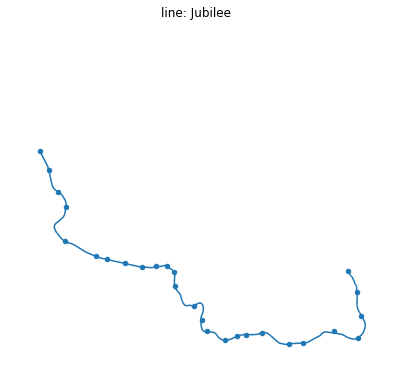

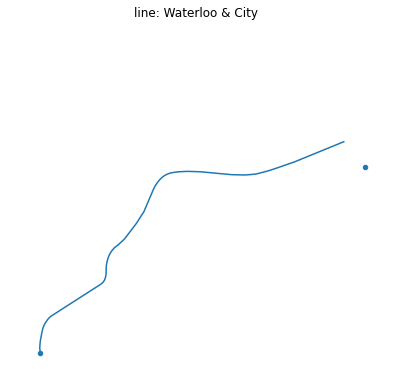

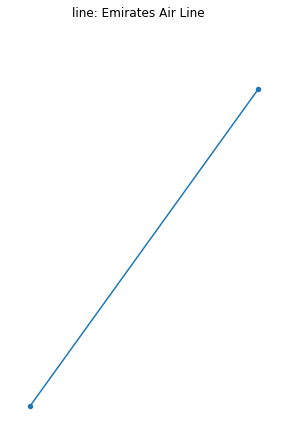

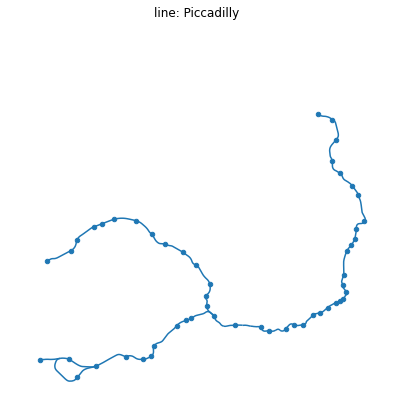

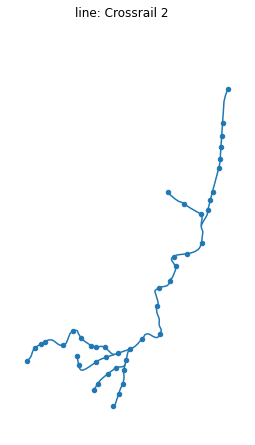

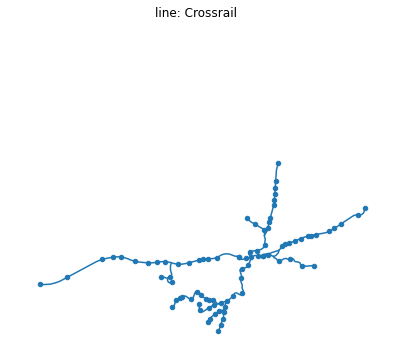

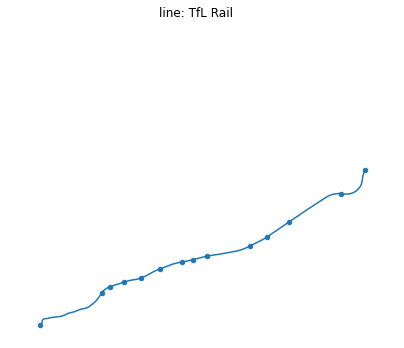

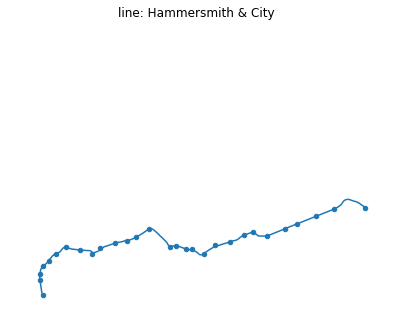

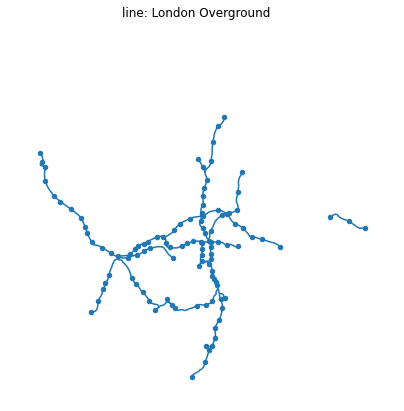

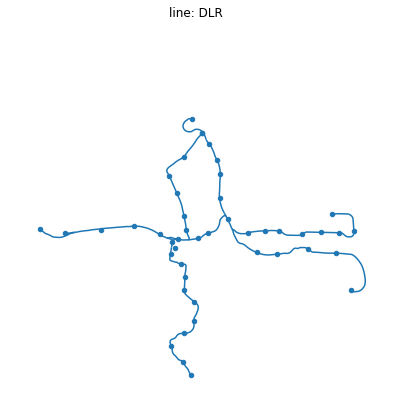

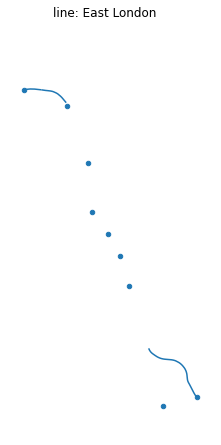

In [12]:
# check the data for each line
for line in line_names:
    #I'm removing thameslink 6tph line because there are not corresponding stations in station file
    if line == 'Thameslink 6tph line':
        continue
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    temp_lines = lines[lines.lines.str.contains(line)]
    base = temp_lines.plot(ax=ax)
    temp_stations = stations[stations.lines.str.contains(line)]
    temp_stations.plot(ax=base, markersize=20)
    plt.show()

In [13]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [14]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

##### Create graph

Circle


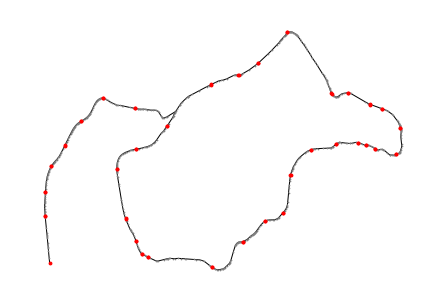

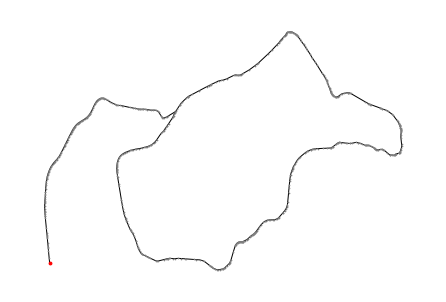

1
Bakerloo


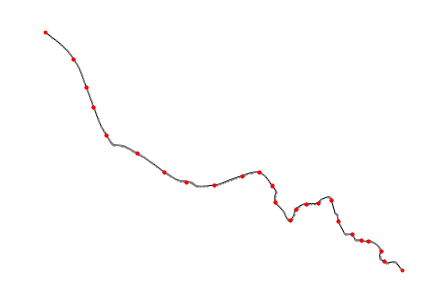

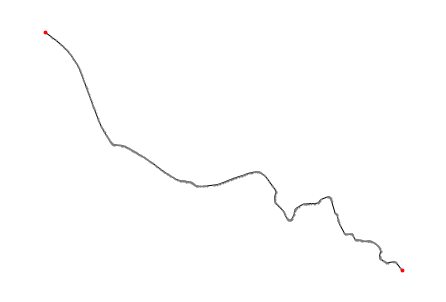

1
Victoria


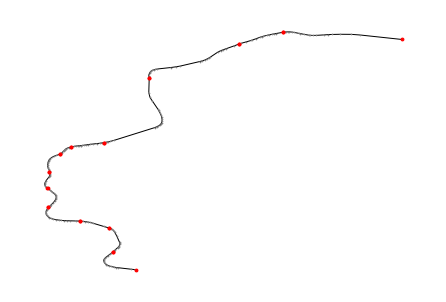

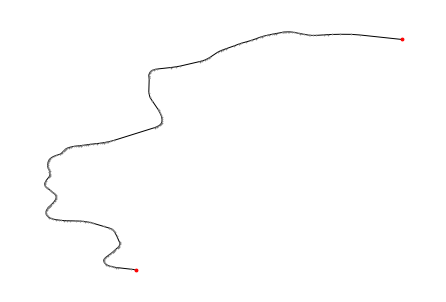

1
District


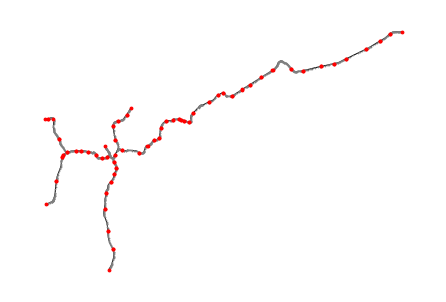

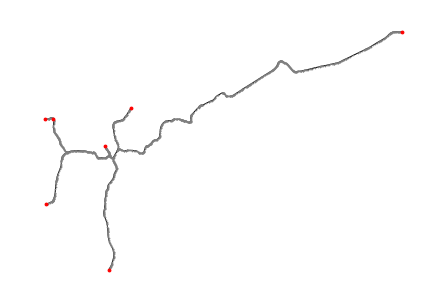

1
Northern


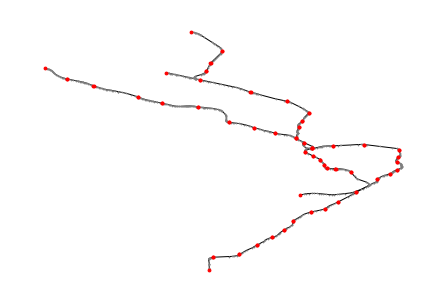

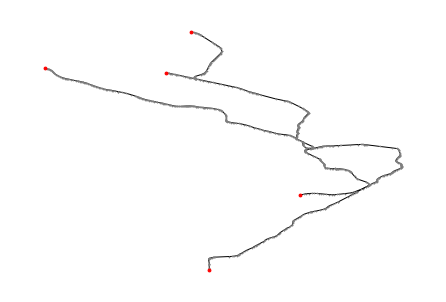

1
Metropolitan


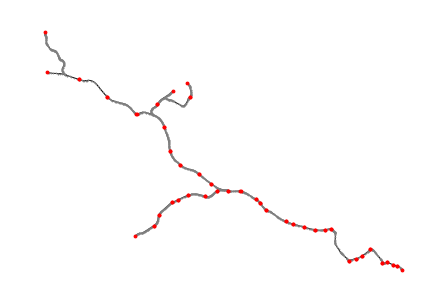

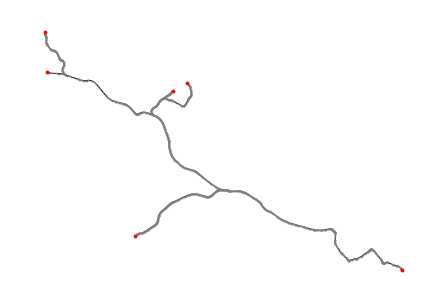

1
Central


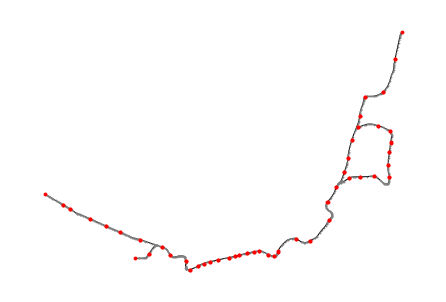

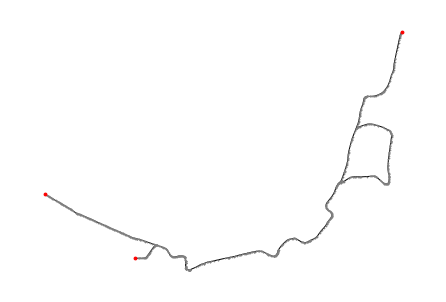

1
Jubilee


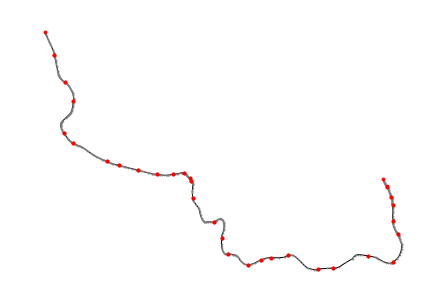

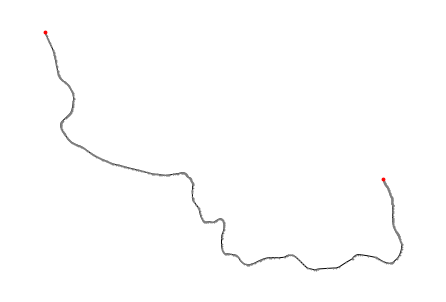

1
Waterloo & City


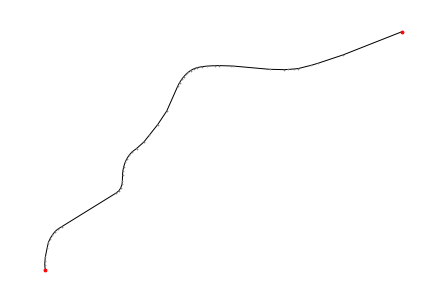

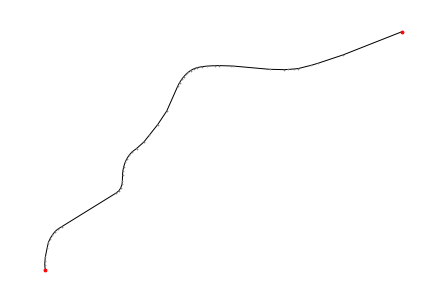

1
Piccadilly


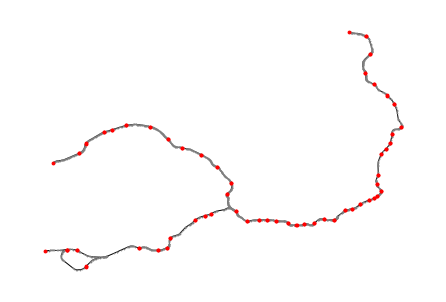

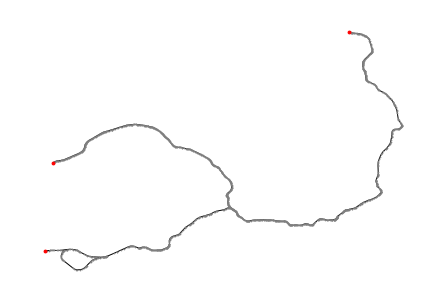

1
TfL Rail


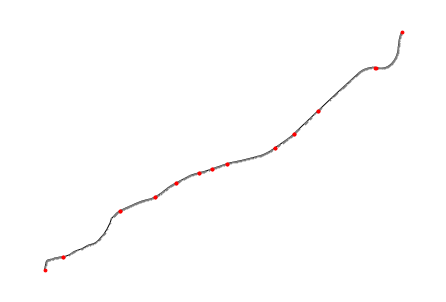

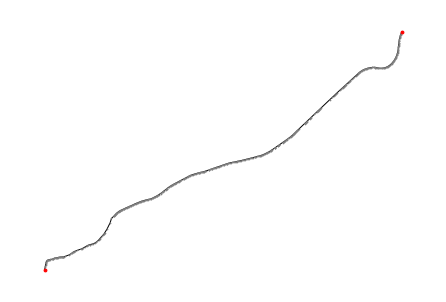

1
Hammersmith & City


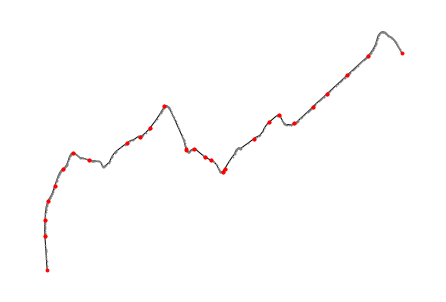

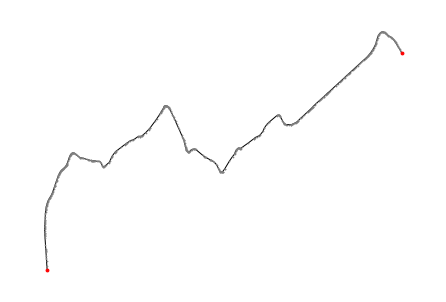

1
London Overground


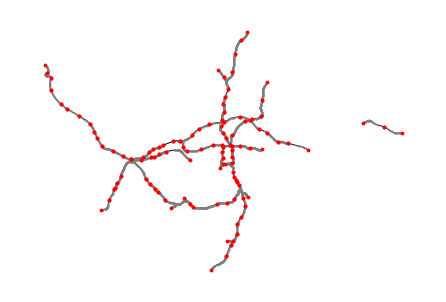

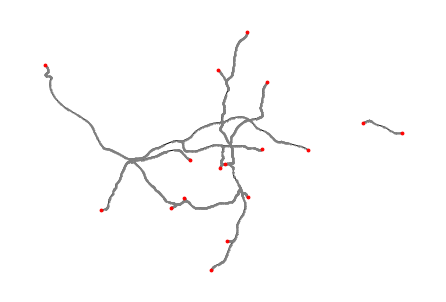

3
DLR


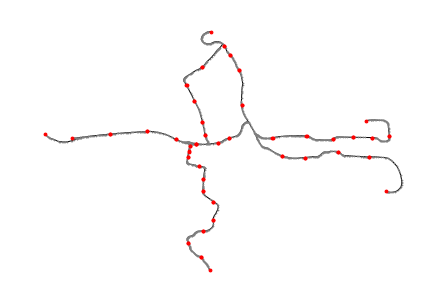

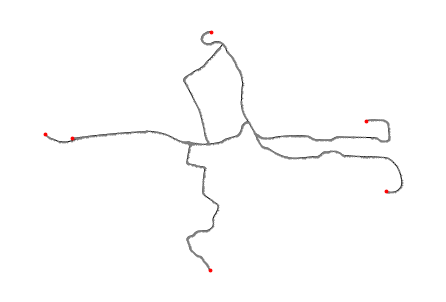

1


In [15]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G

In [16]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Circle,940GZZLUSKS,940GZZLUSSQ,"LINESTRING (526936.100 178814.992, 528077.438 ..."
1,Circle,940GZZLUSKS,940GZZLUGTR,"LINESTRING (526936.100 178814.992, 526201.148 ..."
2,Circle,940GZZLUGTR,940GZZLUHSK,"LINESTRING (526201.148 178841.352, 525545.491 ..."
3,Circle,940GZZLUHSK,940GZZLUGTR,"LINESTRING (525545.491 179548.695, 526201.148 ..."
4,Circle,940GZZLUHSK,940GZZLUNHG,"LINESTRING (525545.491 179548.695, 525284.469 ..."


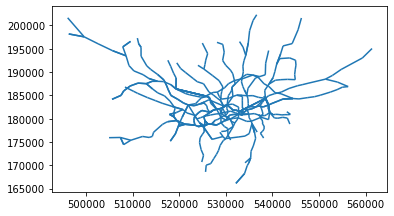

In [17]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

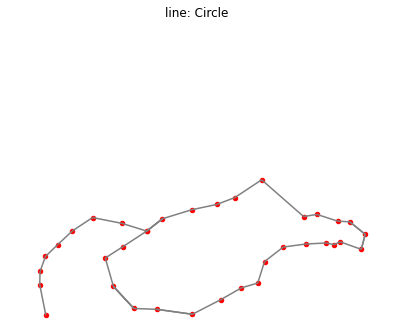

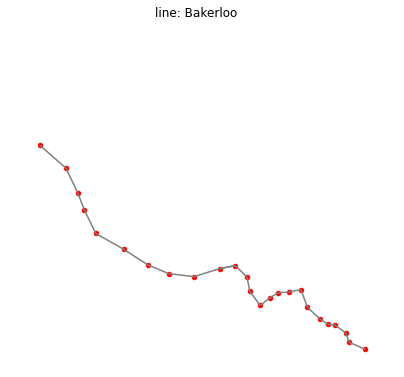

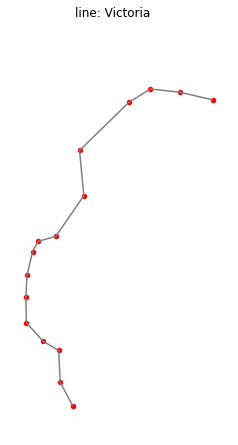

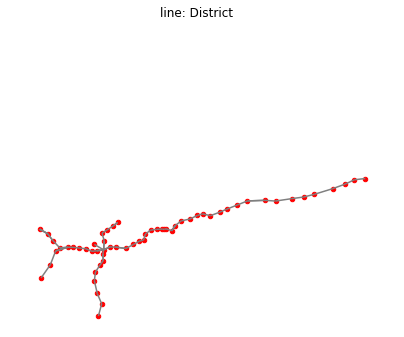

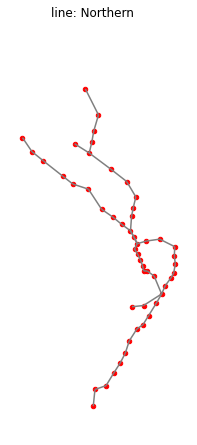

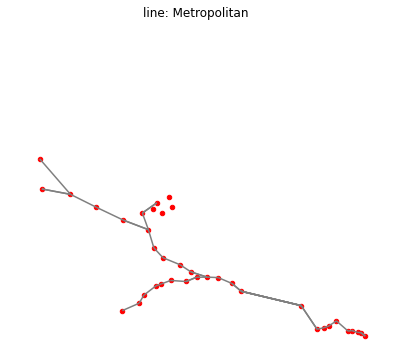

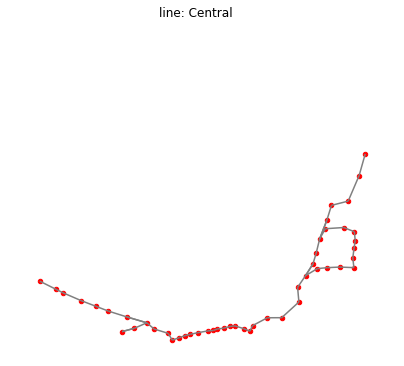

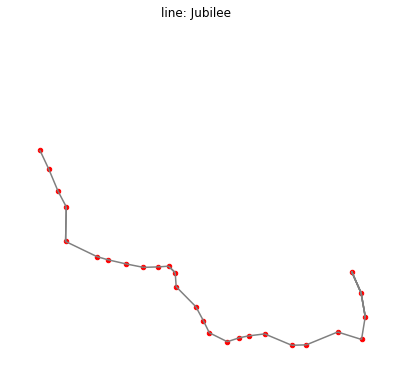

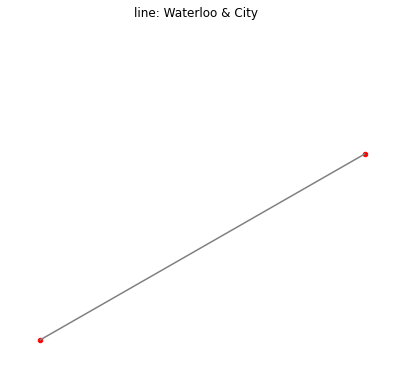

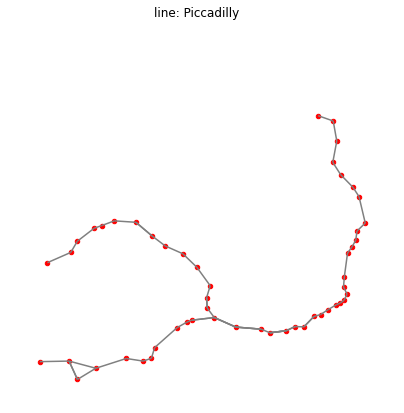

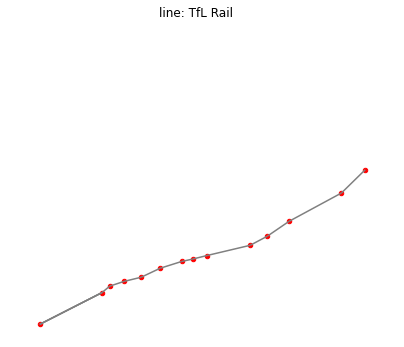

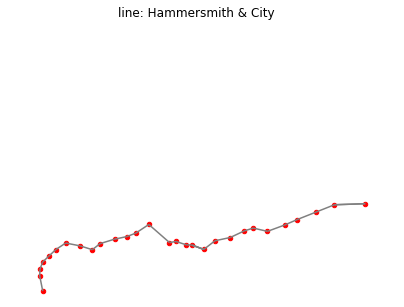

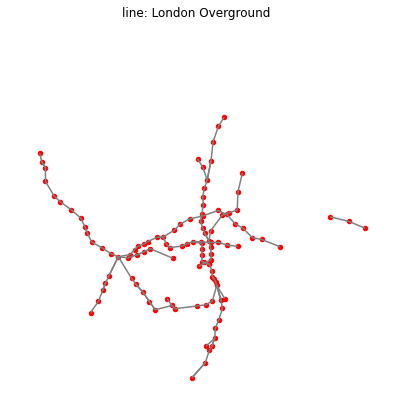

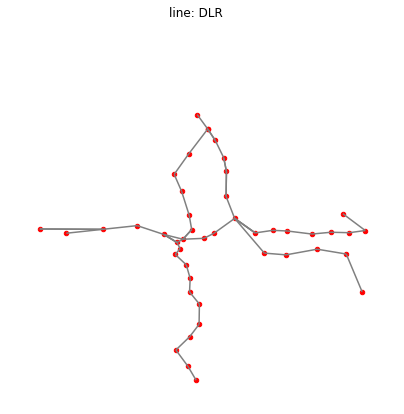

In [18]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<AxesSubplot:>

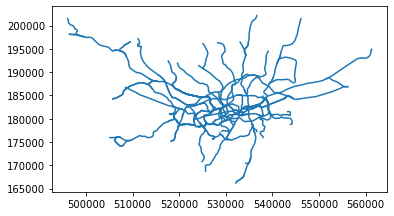

In [19]:
#plot to sanity check
edge_gdf.plot()

In [20]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [21]:
#let's replace the ids with the actual nane
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [22]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [23]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'Piccadilly', 'District', 'Circle', 'Bakerloo', 'Northern', 'DLR', 'Hammersmith & City', 'Central', 'Metropolitan', 'TfL Rail', 'Jubilee', 'London Overground', 'Waterloo & City', 'Victoria'}


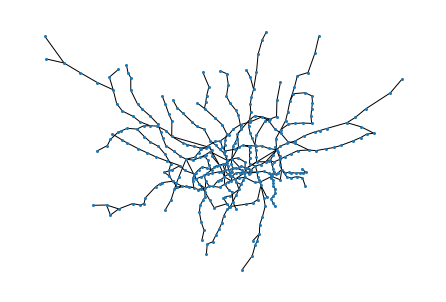

In [24]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [25]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [26]:
list(G.nodes(data = True))[0]

('South Kensington', {'coords': (526936.099773122, 178814.99207851745)})

In [27]:
list(G.edges(data = True))[0]

('South Kensington',
 'Sloane Square',
 {'length': 1173.2223716014348, 'line_name': 'District'})

In [28]:
# we can also add the stations name to the edge attributes from the nodes attributes:

nod_name1={(e1,e2):e1 for e1, e2 in G.edges()}
nod_name2={(e1,e2):e2 for e1, e2 in G.edges()}
nod_name3={e1:e1 for e1 in G.nodes()}

nx.set_edge_attributes(G,nod_name1,'station_1_')
nx.set_edge_attributes(G,nod_name2,'station_2_')
nx.set_node_attributes(G,nod_name3,'station_name')

In [29]:
#check
list(G.nodes(data = True))[0]

('South Kensington',
 {'coords': (526936.099773122, 178814.99207851745),
  'station_name': 'South Kensington'})

In [30]:
#check
list(G.edges(data = True))[0]

('South Kensington',
 'Sloane Square',
 {'length': 1173.2223716014348,
  'line_name': 'District',
  'station_1_': 'South Kensington',
  'station_2_': 'Sloane Square'})

##### Check work

In [31]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [32]:
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street

[('Edgware Road', 'Baker Street'),
 ('Baker Street', 'Great Portland Street'),
 ('Baker Street', 'Marylebone'),
 ('Baker Street', "Regent's Park"),
 ('Baker Street', 'Finchley Road'),
 ('Baker Street', 'Bond Street'),
 ('Baker Street', "St. John's Wood")]

In [33]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

In [34]:
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

In [35]:
df.sort_values('degree', ascending =False).head(10)

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Oxford Circus,6
Earl's Court,6
Canning Town,6
Liverpool Street,6
Green Park,6
West Ham,6


#### Centrality

##### Degree

In [36]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

In [37]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'), dtype='object')
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_sorted_dc = df.sort_values(["degree"], ascending=False)
df_sorted_dc[0:10]

,station_name,degree
Stratford,Stratford,0.0225
Bank and Monument,Bank and Monument,0.0200
Baker Street,Baker Street,0.0175
King's Cross St. Pancras,King's Cross St. Pancras,0.0175
Oxford Circus,Oxford Circus,0.0150
Earl's Court,Earl's Court,0.0150
Canning Town,Canning Town,0.0150
Liverpool Street,Liverpool Street,0.0150
Green Park,Green Park,0.0150
West Ham,West Ham,0.0150


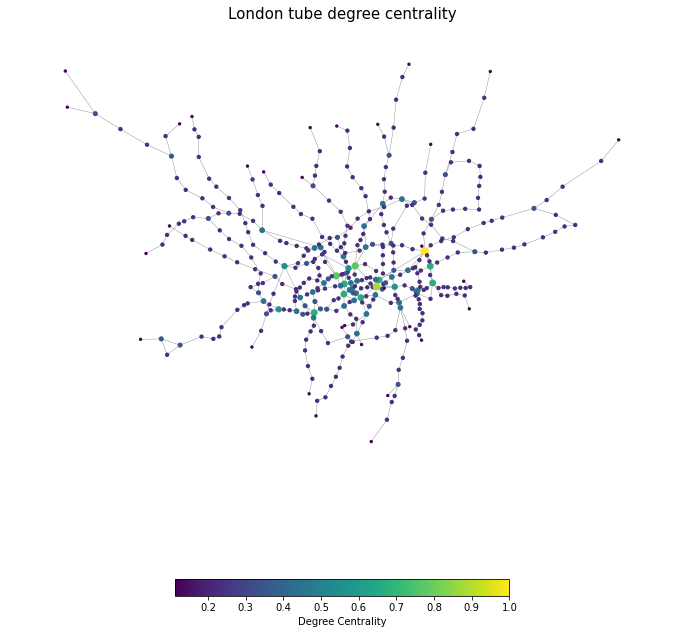

In [38]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]

# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

##### Bet

In [39]:
### Topological betweenness centrality:
#Let us compute the betweenness centrality for the network, without using weights:

bet_london_t=nx.betweenness_centrality(G, normalized=False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')

In [40]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_sorted_bc = df.sort_values(["betweenness_t"], ascending=False)
df_sorted_bc[0:10]

,station_name,betweenness_t
Stratford,Stratford,23768.093434
Bank and Monument,Bank and Monument,23181.058947
Liverpool Street,Liverpool Street,21610.387049
King's Cross St. Pancras,King's Cross St. Pancras,20373.521465
Waterloo,Waterloo,19464.882323
Green Park,Green Park,17223.622114
Euston,Euston,16624.275469
Westminster,Westminster,16226.155916
Baker Street,Baker Street,15287.107612
Finchley Road,Finchley Road,13173.758009


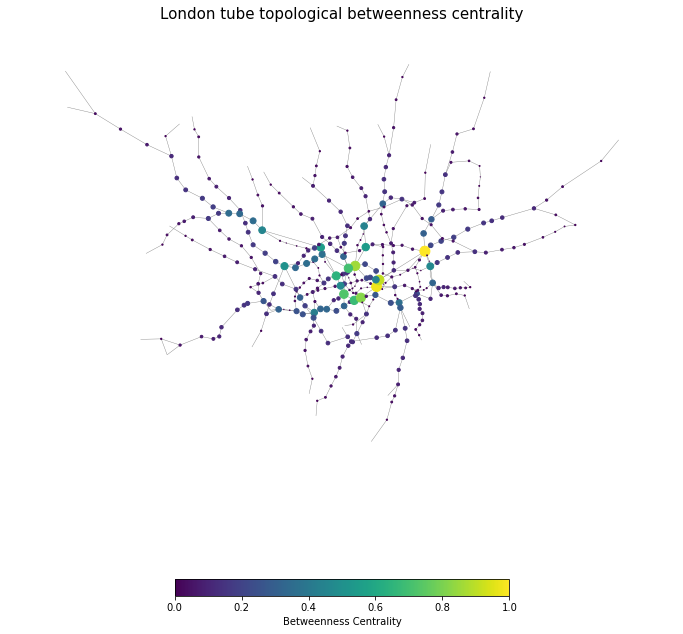

In [41]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

##### Close

In [42]:
#topological closeness centrality 
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_sorted_cc = df.sort_values(["closeness_t"], ascending=False)
df_sorted_cc[0:10]

,station_name,closeness_t
Green Park,Green Park,0.114778
Bank and Monument,Bank and Monument,0.113572
King's Cross St. Pancras,King's Cross St. Pancras,0.113443
Westminster,Westminster,0.112549
Waterloo,Waterloo,0.112265
Oxford Circus,Oxford Circus,0.111204
Bond Street,Bond Street,0.110988
Angel,Angel,0.110742
Farringdon,Farringdon,0.110742
Moorgate,Moorgate,0.110314


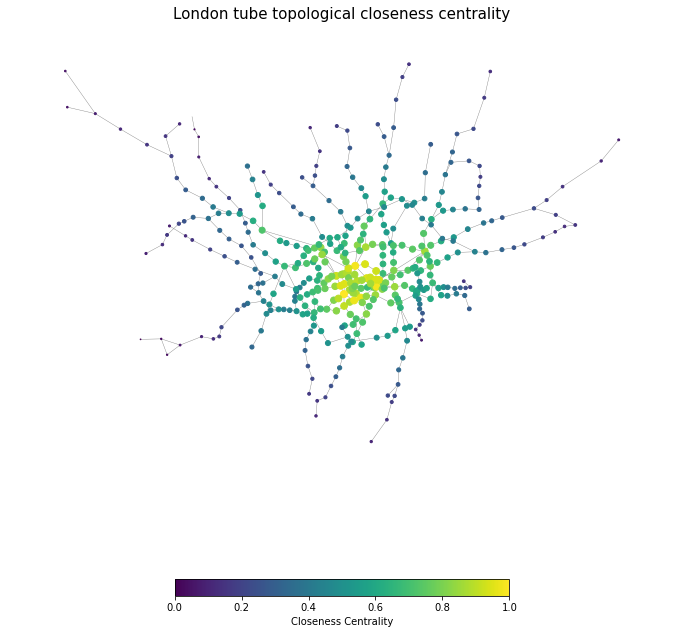

In [43]:
# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

#### Impact measure

##### Strategy A

###### Degree

In [44]:
Ga_dc=G.copy()

In [45]:
lcc_data_a_dc = []
avg_clustering_data_a_dc = []

# 按照df_sorted[0:10]的顺序每次移除一个节点
for i, node in enumerate(df_sorted_dc[0:10].index, start=1):
    # 移除节点
    Ga_dc.remove_node(node)
    
    # 计算LCC
    Gcc = sorted(nx.connected_components(Ga_dc), key=len, reverse=True)
    Gsub = Ga_dc.subgraph(Gcc[0])

    # 计算最大连通分量中的节点百分比
    percent_lcc = (len(Gsub.nodes) / len(Ga_dc.nodes)) * 100
    lcc_data_a_dc.append(percent_lcc)
    
    # 计算聚类系数
    c = nx.clustering(Gsub)
    
    # 计算平均聚类系数
    c_avg = sum(c.values()) / len(c)
    avg_clustering_data_a_dc.append(c_avg)

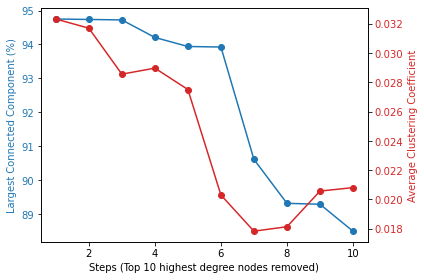

In [46]:
# 绘制LCC和平均聚类系数的图表
fig, ax1 = plt.subplots()

ax1.set_xlabel('Steps (Top 10 highest degree nodes removed)')
ax1.set_ylabel('Largest Connected Component (%)', color='tab:blue')
ax1.plot(range(1, 11), lcc_data_a_dc, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Clustering Coefficient', color='tab:red')
ax2.plot(range(1, 11), avg_clustering_data_a_dc, color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()

###### Bet

In [47]:
Ga_bc=G.copy()

In [48]:
df_sorted_bc[0:10]

,station_name,betweenness_t
Stratford,Stratford,23768.093434
Bank and Monument,Bank and Monument,23181.058947
Liverpool Street,Liverpool Street,21610.387049
King's Cross St. Pancras,King's Cross St. Pancras,20373.521465
Waterloo,Waterloo,19464.882323
Green Park,Green Park,17223.622114
Euston,Euston,16624.275469
Westminster,Westminster,16226.155916
Baker Street,Baker Street,15287.107612
Finchley Road,Finchley Road,13173.758009


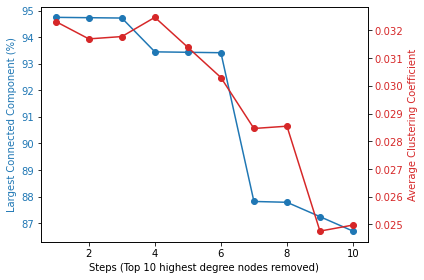

In [49]:
lcc_data_a_bc = []
avg_clustering_data_a_bc = []

# 按照df_sorted[0:10]的顺序每次移除一个节点
for i, node in enumerate(df_sorted_bc[0:10].index, start=1):
    # 移除节点
    Ga_bc.remove_node(node)
    
    # 计算LCC
    Gcc = sorted(nx.connected_components(Ga_bc), key=len, reverse=True)
    Gsub = Ga_bc.subgraph(Gcc[0])

    # 计算最大连通分量中的节点百分比
    percent_lcc = (len(Gsub.nodes) / len(Ga_bc.nodes)) * 100
    lcc_data_a_bc.append(percent_lcc)
    
    # 计算聚类系数
    c = nx.clustering(Gsub)
    
    # 计算平均聚类系数
    c_avg = sum(c.values()) / len(c)
    avg_clustering_data_a_bc.append(c_avg)
    
# 绘制LCC和平均聚类系数的图表
fig, ax1 = plt.subplots()

ax1.set_xlabel('Steps (Top 10 highest degree nodes removed)')
ax1.set_ylabel('Largest Connected Component (%)', color='tab:blue')
ax1.plot(range(1, 11), lcc_data_a_bc, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Clustering Coefficient', color='tab:red')
ax2.plot(range(1, 11), avg_clustering_data_a_bc, color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

###### Close

In [50]:
Ga_cc=G.copy()

In [51]:
df_sorted_cc[0:10]

,station_name,closeness_t
Green Park,Green Park,0.114778
Bank and Monument,Bank and Monument,0.113572
King's Cross St. Pancras,King's Cross St. Pancras,0.113443
Westminster,Westminster,0.112549
Waterloo,Waterloo,0.112265
Oxford Circus,Oxford Circus,0.111204
Bond Street,Bond Street,0.110988
Angel,Angel,0.110742
Farringdon,Farringdon,0.110742
Moorgate,Moorgate,0.110314


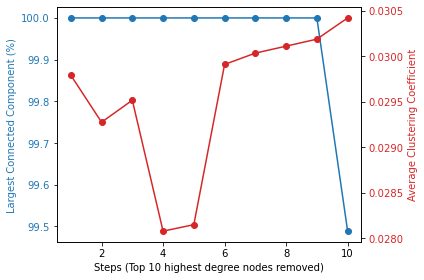

In [52]:
lcc_data_a_cc = []
avg_clustering_data_a_cc = []

# 按照df_sorted[0:10]的顺序每次移除一个节点
for i, node in enumerate(df_sorted_cc[0:10].index, start=1):
        
    # 移除节点
    Ga_cc.remove_node(node)
    
    # 计算LCC
    Gcc = sorted(nx.connected_components(Ga_cc), key=len, reverse=True)
    Gsub = Ga_cc.subgraph(Gcc[0])

    # 计算最大连通分量中的节点百分比
    percent_lcc = (len(Gsub.nodes) / len(Ga_cc.nodes)) * 100
    lcc_data_a_cc.append(percent_lcc)
    
    # 计算聚类系数
    c = nx.clustering(Gsub)
    
    # 计算平均聚类系数
    c_avg = sum(c.values()) / len(c)
    avg_clustering_data_a_cc.append(c_avg)
    


# 绘制LCC和平均聚类系数的图表
fig, ax1 = plt.subplots()

ax1.set_xlabel('Steps (Top 10 highest degree nodes removed)')
ax1.set_ylabel('Largest Connected Component (%)', color='tab:blue')
ax1.plot(range(1, 11), lcc_data_a_cc, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Clustering Coefficient', color='tab:red')
ax2.plot(range(1, 11), avg_clustering_data_a_cc, color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

##### Strategy B

###### Degree

In [53]:
Gb_dc = G.copy()

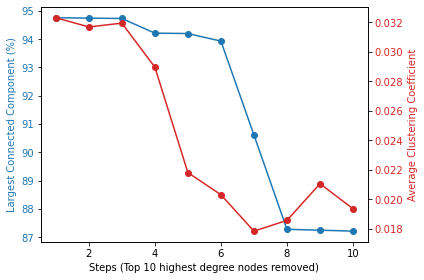

In [54]:
# 初始化数据列表
lcc_data = []
avg_clustering_data = []

# 重复计算度中心性并移除度中心性最高的节点10次
for i in range(1, 11):
    # 计算度中心性
    deg_london = nx.degree_centrality(Gb_dc)
    nx.set_node_attributes(Gb_dc, dict(deg_london), 'degree')
    
    # 更新DataFrame
    df = pd.DataFrame(index=Gb_dc.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(Gb_dc, 'station_name'))
    df['degree'] = pd.Series(nx.get_node_attributes(Gb_dc, 'degree'))
    df_sorted_dc = df.sort_values(["degree"], ascending=False)
    
    # 移除度中心性最高的节点
    node_to_remove = df_sorted_dc.index[0]
    Gb_dc.remove_node(node_to_remove)
    
    # 计算LCC
    Gcc = sorted(nx.connected_components(Gb_dc), key=len, reverse=True)
    Gsub = Gb_dc.subgraph(Gcc[0])

    # 计算最大连通分量中的节点百分比
    percent_lcc = (len(Gsub.nodes) / len(Gb_dc.nodes)) * 100
    lcc_data.append(percent_lcc)
    
    # 计算聚类系数
    c = nx.clustering(Gsub)
    
    # 计算平均聚类系数
    c_avg = sum(c.values()) / len(c)
    avg_clustering_data.append(c_avg)

# 绘制LCC和平均聚类系数的图表
fig, ax1 = plt.subplots()

ax1.set_xlabel('Steps (Top 10 highest degree nodes removed)')
ax1.set_ylabel('Largest Connected Component (%)', color='tab:blue')
ax1.plot(range(1, 11), lcc_data, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Clustering Coefficient', color='tab:red')
ax2.plot(range(1, 11), avg_clustering_data, color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

###### Bet

In [55]:
Gb_bc = G.copy()

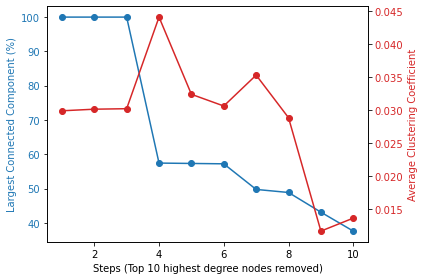

In [56]:
# 初始化数据列表
lcc_data = []
avg_clustering_data = []

# 重复计算度中心性并移除度中心性最高的节点10次
for i in range(1, 11):
    # 计算介数中心性
    bet_london_t=nx.betweenness_centrality(Gb_bc,weight='length',normalized=False)
    nx.set_node_attributes(Gb_bc,bet_london_t,'betweenness_t')
    
    # 更新DataFrame
    df = pd.DataFrame(index=Gb_bc.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(Gb_bc, 'station_name'))
    df['betweenness_t'] = pd.Series(nx.get_node_attributes(Gb_bc, 'betweenness_t'))
    df_sorted_bc = df.sort_values(["betweenness_t"], ascending=False)
    
    # 移除介数中心性最高的节点
    node_to_remove = df_sorted_bc.index[0]
    Gb_bc.remove_node(node_to_remove)
    
    # 计算LCC
    Gcc = sorted(nx.connected_components(Gb_bc), key=len, reverse=True)
    Gsub = Gb_bc.subgraph(Gcc[0])

    # 计算最大连通分量中的节点百分比
    percent_lcc = (len(Gsub.nodes) / len(Gb_bc.nodes)) * 100
    lcc_data.append(percent_lcc)
    
    # 计算聚类系数
    c = nx.clustering(Gsub)
    
    # 计算平均聚类系数
    c_avg = sum(c.values()) / len(c)
    avg_clustering_data.append(c_avg)

# 绘制LCC和平均聚类系数的图表
fig, ax1 = plt.subplots()

ax1.set_xlabel('Steps (Top 10 highest degree nodes removed)')
ax1.set_ylabel('Largest Connected Component (%)', color='tab:blue')
ax1.plot(range(1, 11), lcc_data, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Clustering Coefficient', color='tab:red')
ax2.plot(range(1, 11), avg_clustering_data, color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

###### Close

In [57]:
Gb_cc = G.copy()

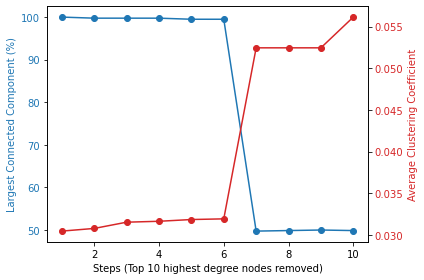

In [58]:
# 初始化数据列表
lcc_data = []
avg_clustering_data = []

# 重复计算度中心性并移除度中心性最高的节点10次
for i in range(1, 11):
    # 计算介数中心性
    clos_t=nx.closeness_centrality(Gb_cc, distance='length')
    nx.set_node_attributes(Gb_cc,clos_t,'closeness_t')
    
    # 更新DataFrame
    df = pd.DataFrame(index=Gb_cc.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(Gb_cc, 'station_name'))
    df['closeness_t'] = pd.Series(nx.get_node_attributes(Gb_cc, 'closeness_t'))
    df_sorted_cc = df.sort_values(["closeness_t"], ascending=False)
    
    # 移除介数中心性最高的节点
    node_to_remove = df_sorted_cc.index[0]
    Gb_cc.remove_node(node_to_remove)
    
    # 计算LCC
    Gcc = sorted(nx.connected_components(Gb_cc), key=len, reverse=True)
    Gsub = Gb_cc.subgraph(Gcc[0])

    # 计算最大连通分量中的节点百分比
    percent_lcc = (len(Gsub.nodes) / len(Gb_cc.nodes)) * 100
    lcc_data.append(percent_lcc)
    
    # 计算聚类系数
    c = nx.clustering(Gsub)
    
    # 计算平均聚类系数
    c_avg = sum(c.values()) / len(c)
    avg_clustering_data.append(c_avg)

# 绘制LCC和平均聚类系数的图表
fig, ax1 = plt.subplots()

ax1.set_xlabel('Steps (Top 10 highest degree nodes removed)')
ax1.set_ylabel('Largest Connected Component (%)', color='tab:blue')
ax1.plot(range(1, 11), lcc_data, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Clustering Coefficient', color='tab:red')
ax2.plot(range(1, 11), avg_clustering_data, color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

### II Flows

#### Prepare

In [59]:
flow_OD = pd.read_csv('london_flows.csv')

In [60]:
#check that our OD data and network data match
OD_names = set(flow_OD.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [61]:
#let's filter out the stations that we don't have in our network
_filter = list(network_names.symmetric_difference(OD_names))
flow_OD = flow_OD[~flow_OD.station_origin.isin(_filter)]
flow_OD = flow_OD[~flow_OD.station_destination.isin(_filter)]

In [62]:
#Add flow data to our network
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [63]:
#calculate shortest paths for all flows and add data to dict
for i, row in flow_OD.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [64]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

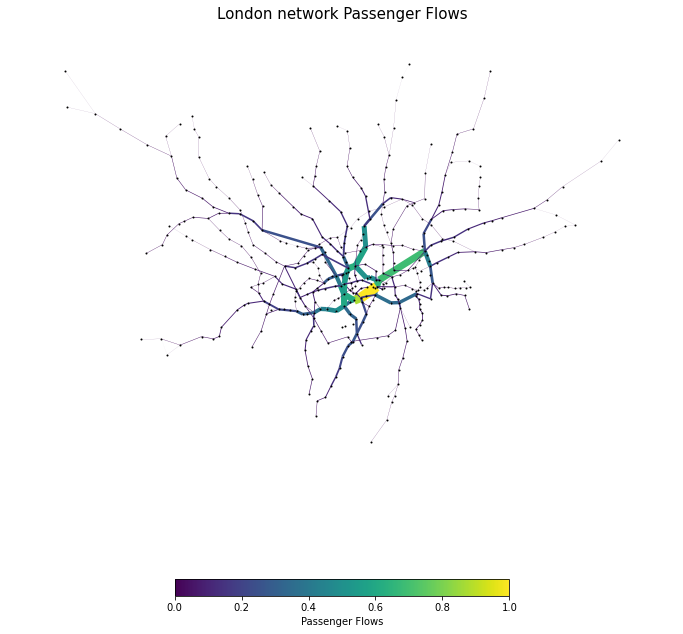

In [65]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [66]:
#get edge with highest number of flows
max(flows, key=flows.get)

('Bank and Monument', 'Waterloo')

In [67]:
#get edge data with lowest number of flows
min(flows, key=flows.get)

('Kennington', 'Nine Elms')

In [68]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "london.graph")

#### II.1

In [69]:
G4 = G.copy()

##### Degree

In [70]:
# Check info of G4
df = nx.to_pandas_edgelist(G4)
df_sorted = df.sort_values(by='flows', ascending=False)
df_sorted[0:10]

,source,target,line_name,station_1_,length,flows,station_2_
36,Bank and Monument,Waterloo,Waterloo & City,Bank and Monument,2542.954444,221381,Waterloo
22,Westminster,Waterloo,Jubilee,Westminster,850.360026,193217,Waterloo
43,Liverpool Street,Stratford,TfL Rail,Liverpool Street,6698.461270,152996,Stratford
35,Bank and Monument,Liverpool Street,Central,Bank and Monument,841.502684,146459,Liverpool Street
54,King's Cross St. Pancras,Euston,Northern,King's Cross St. Pancras,888.358727,141365,Euston
23,Westminster,Green Park,Jubilee,Westminster,1423.780195,134152,Green Park
19,Victoria,Green Park,Victoria,Victoria,1209.599809,133141,Green Park
91,Oxford Circus,Green Park,Victoria,Oxford Circus,1010.566475,130660,Green Park
55,King's Cross St. Pancras,Highbury & Islington,Victoria,King's Cross St. Pancras,2581.853010,128514,Highbury & Islington
92,Oxford Circus,Warren Street,Victoria,Oxford Circus,1149.714446,121465,Warren Street


In [71]:
deg_london_weighted = G4.degree(weight='flows')
nx.set_node_attributes(G4, dict(deg_london_weighted), 'weighted_degree')

df = pd.DataFrame(index=G4.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G4, 'station_name'), dtype='object')
df['weighted_degree'] = pd.Series(nx.get_node_attributes(G4, 'weighted_degree'))

df_sorted_dc_weighted = df.sort_values(["weighted_degree"], ascending=False)
df_sorted_dc_weighted[0:10]

,station_name,weighted_degree
Bank and Monument,Bank and Monument,619863
Waterloo,Waterloo,542058
Green Park,Green Park,534070
King's Cross St. Pancras,King's Cross St. Pancras,482833
Westminster,Westminster,427715
Liverpool Street,Liverpool Street,398979
Victoria,Victoria,397544
Euston,Euston,374476
Stratford,Stratford,365735
Oxford Circus,Oxford Circus,335638


##### Between

In [72]:
bet_london_w=nx.betweenness_centrality(G4,weight='flows',normalized=False)
nx.set_node_attributes(G4,bet_london_w,'betweenness_w')

df = pd.DataFrame(index=G4.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G4, 'station_name'))
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G4, 'betweenness_w'))

df_sorted_bc_weighted = df.sort_values(["betweenness_w"], ascending=False)
df_sorted_bc_weighted[0:10]

,station_name,betweenness_w
West Hampstead,West Hampstead,31437.00
Gospel Oak,Gospel Oak,25865.50
Finchley Road & Frognal,Finchley Road & Frognal,24728.50
Hampstead Heath,Hampstead Heath,24681.50
Willesden Junction,Willesden Junction,23121.00
Brondesbury,Brondesbury,20477.25
Brondesbury Park,Brondesbury Park,20362.75
Kensal Rise,Kensal Rise,20248.75
Stratford,Stratford,16928.25
Kentish Town West,Kentish Town West,14354.50


##### Close

In [73]:
clos_w=nx.closeness_centrality(G4, distance='flows')
nx.set_node_attributes(G4,clos_w,'closeness_w')

df = pd.DataFrame(index=G4.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G4, 'station_name'))
df['closeness_w'] = pd.Series(nx.get_node_attributes(G4, 'closeness_w'))

df_sorted_cc_weight = df.sort_values(["closeness_w"], ascending=False)
df_sorted_cc_weight[0:10]

,station_name,closeness_w
West Hampstead,West Hampstead,0.000006
Finchley Road & Frognal,Finchley Road & Frognal,0.000006
Hampstead Heath,Hampstead Heath,0.000006
Brondesbury,Brondesbury,0.000006
Gospel Oak,Gospel Oak,0.000006
Upper Holloway,Upper Holloway,0.000006
Kentish Town West,Kentish Town West,0.000006
Crouch Hill,Crouch Hill,0.000006
Brondesbury Park,Brondesbury Park,0.000006
Camden Road,Camden Road,0.000006


#### II.2

#### II.3

In [74]:
def custom_global_efficiency(G):
    n = len(G.nodes)
    total_shortest_paths = 0
    
    for node1 in G.nodes:
        shortest_paths = nx.single_source_dijkstra_path_length(G, node1, weight=None)
        for node2, length in shortest_paths.items():
            if node1 != node2:
                total_shortest_paths += 1 / length

    efficiency = total_shortest_paths / ((len(list(G.nodes))-1)*len(list(G.nodes)))
    return efficiency

##### A

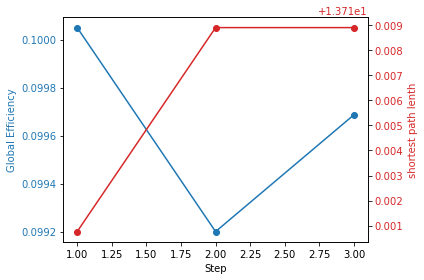

In [75]:
Gc = G.copy()

global_efficiency_values = []
ave_path = []
# Remove top 3 nodes with the highest betweenness centrality and calculate global efficiency
for i, node in enumerate(df_sorted_bc_weighted[0:3].index, start=1):
    Gc.remove_node(node)
    
    global_efficiency = custom_global_efficiency(Gc)
    global_efficiency_values.append(global_efficiency)
    
    # Find the largest connected component
    Gcc = sorted(nx.connected_components(Gc), key=len, reverse=True)
    G_largest_cc = Gc.subgraph(Gcc[0])
    
    ave_shor_path = round(nx.average_shortest_path_length(G_largest_cc), 6)
    ave_path.append(ave_shor_path)
    
# Plot the results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Step')
ax1.set_ylabel('Global Efficiency', color='tab:blue')
ax1.plot(range(1, 4), global_efficiency_values, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('shortest path lenth', color='tab:red')
ax2.plot(range(1, 4), ave_path, color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

##### B

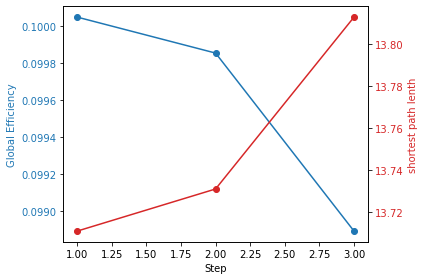

In [76]:
Gcb = G.copy()

global_efficiency_values = []
ave_path = []
# Remove top 3 nodes with the highest betweenness centrality and calculate global efficiency
for i in range(1, 4):
    bet_london_w = nx.betweenness_centrality(Gcb, weight='flows', normalized=False)
    nx.set_node_attributes(Gcb,bet_london_w,'betweenness_w')
    
    df = pd.DataFrame(index=Gcb.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(Gcb, 'station_name'))
    df['betweenness_w'] = pd.Series(nx.get_node_attributes(Gcb, 'betweenness_w'))
    df_sorted_bc_weighted_b = df.sort_values(["betweenness_w"], ascending=False)
    
    node_to_remove = df_sorted_bc_weighted_b.index[0]
    Gcb.remove_node(node_to_remove)
    
    global_efficiency = custom_global_efficiency(Gcb)
    global_efficiency_values.append(global_efficiency)
    
    # Find the largest connected component
    Gcc = sorted(nx.connected_components(Gcb), key=len, reverse=True)
    G_largest_cc = Gcb.subgraph(Gcc[0])
    
    ave_shor_path = round(nx.average_shortest_path_length(G_largest_cc), 6)
    ave_path.append(ave_shor_path)
    
# Plot the results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Step')
ax1.set_ylabel('Global Efficiency', color='tab:blue')
ax1.plot(range(1, 4), global_efficiency_values, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('shortest path lenth', color='tab:red')
ax2.plot(range(1, 4), ave_path, color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

## Part 2

### Prepare

In [77]:
#### Create Origin Destination matrix
OD = pd.pivot_table(flow_OD, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.to_csv('OD_matrix.csv')

In [78]:
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24735
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,27026
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28307
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29494
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31473
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32597
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37517
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59311
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67372


In [79]:
#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

In [80]:
#lets add this data as population and jobs
flow_OD['population'] = flow_OD.station_origin.apply(lambda x: origin[x])
flow_OD['jobs'] = flow_OD.station_destination.apply(lambda x: destination[x])

In [81]:
#get distance between stations withion the network
flow_OD['distance'] = -1
for i, row in flow_OD.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    flow_OD.loc[i, 'distance'] = distance

# or you could use all_pairs_dijkstra_path_length(G, weight='length') to get all distances at once...

In [82]:
flow_OD.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


### Scenario

#### IV.1

#### IV.2

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

In [84]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [85]:
zeros = flow_OD.apply(lambda x: any(x == 0), axis=1)
flow_OD_zeros = flow_OD[~zeros]

In [86]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    flow_OD_zeros[f"log_{x}"] = np.log(flow_OD_zeros[x])
    log_x_vars.append(f"log_{x}")

/tmp/ipykernel_14123/3584775316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_OD_zeros[f"log_{x}"] = np.log(flow_OD_zeros[x])
/tmp/ipykernel_14123/3584775316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_OD_zeros[f"log_{x}"] = np.log(flow_OD_zeros[x])
/tmp/ipykernel_14123/3584775316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [87]:
flow_OD_zeros_mat = pd.pivot_table(flow_OD_zeros, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_zeros_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [88]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobs + log_distance-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=flow_OD_zeros, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43545
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.1461e+05
Date:                Sun, 30 Apr 2023   Deviance:                   1.6570e+06
Time:                        19:47:42   Pearson chi2:                 2.41e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [89]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flow_OD_zeros.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flow_OD_zeros = flow_OD_zeros.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flow_OD_zeros.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flow_OD_zeros = flow_OD_zeros.merge(D_j, on = "station_destination", how = "left" )

In [90]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
flow_OD_zeros = flow_OD_zeros.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flow_OD_zeros.drop(columns = ["coef"], inplace = True)
#check this has worked
flow_OD_zeros.head()

/tmp/ipykernel_14123/3483395719.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.261685
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.261685
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.261685
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.261685
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,599,1208,3.261685


In [91]:
alpha_i = prodSim.params[0:397]
gamma = prodSim.params[398]
beta = -prodSim.params[399]

In [92]:
alpha_i

station_origin[Abbey Road]         3.261685
station_origin[Acton Central]      4.999677
station_origin[Acton Town]         4.387753
station_origin[Aldgate]            3.352129
station_origin[Aldgate East]       3.399821
                                     ...   
station_origin[Wood Lane]          3.608322
station_origin[Wood Street]        5.662974
station_origin[Woodford]           4.945393
station_origin[Woodgrange Park]    5.311482
station_origin[Woodside Park]      4.488524
Length: 397, dtype: float64

In [93]:
gamma

0.7305270880776411

In [94]:
beta

0.8144892173958834

In [95]:
flow_OD_zeros["prodsimest1"] = np.exp(flow_OD_zeros["alpha_i"]+gamma*flow_OD_zeros["log_jobs"] 
                                 - beta*flow_OD_zeros["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
flow_OD_zeros.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.261685,1.406676
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.261685,3.675166
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.261685,76.155368
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.261685,56.132958
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,599,1208,3.261685,3.568479
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,599,1748,3.261685,3.842947
6,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,599,850,3.261685,2.813404
7,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,599,611,3.261685,3.324115
8,Abbey Road,East India,2,599,1522,3384.141666,6.395262,7.327781,8.126856,599,1522,3.261685,7.356546
9,Abbey Road,Island Gardens,2,599,691,7706.296370,6.395262,6.538140,8.949793,599,691,3.261685,2.113749


##### Assessing the model output

In [96]:
#first round the estimates
flow_OD_zeros["prodsimest1"] = round(flow_OD_zeros["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flow_OD_zeros_3 = flow_OD_zeros.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_zeros_3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1227.0
Acton Town,NaN,NaN,NaN,20.0,20.0,NaN,10.0,NaN,NaN,22.0,...,18.0,4.0,6.0,14.0,NaN,NaN,NaN,NaN,NaN,3749.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,2889.0
Aldgate East,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,6.0,NaN,NaN,3.0,NaN,1.0,NaN,1.0,NaN,3177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,8.0,37.0,41.0,NaN,NaN,NaN,NaN,34.0,...,17.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4871.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,6.0,22.0,22.0,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [97]:
flow_OD_zeros_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [98]:
CalcRSquared(flow_OD_zeros["flows"], flow_OD_zeros["prodsimest1"])

0.3939623174474978

In [99]:
CalcRMSE(flow_OD_zeros["flows"], flow_OD_zeros["prodsimest1"])

120.124

##### A

In [100]:
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["jobs"] / 2
    else:
        val = row["jobs"]
    return val
        
flow_OD_zeros["jobs_change"] = flow_OD_zeros.apply(new_sal, axis =1)
flow_OD_zeros.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,jobs_change
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.261685,1.0,442.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.261685,4.0,665.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.261685,76.0,29386.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.261685,56.0,15428.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,599,1208,3.261685,4.0,1208.0
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,599,1748,3.261685,4.0,1748.0
6,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,599,850,3.261685,3.0,850.0
7,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,599,611,3.261685,3.0,611.0
8,Abbey Road,East India,2,599,1522,3384.141666,6.395262,7.327781,8.126856,599,1522,3.261685,7.0,1522.0
9,Abbey Road,Island Gardens,2,599,691,7706.296370,6.395262,6.538140,8.949793,599,691,3.261685,2.0,691.0


In [101]:
flow_OD_zeros["prodsimest2"] = np.exp(flow_OD_zeros["alpha_i"]+gamma*np.log(flow_OD_zeros["jobs_change"]) - beta*flow_OD_zeros["log_distance"])

flow_OD_zeros["prodsimest2"] = round(flow_OD_zeros["prodsimest2"],0)
#now we can convert the pivot table into a matrix
flow_OD_zeros_4 = flow_OD_zeros.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_zeros_4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,570.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1227.0
Acton Town,NaN,NaN,NaN,20.0,20.0,NaN,10.0,NaN,NaN,22.0,...,18.0,4.0,6.0,14.0,NaN,NaN,NaN,NaN,NaN,3719.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,2862.0
Aldgate East,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,6.0,NaN,NaN,3.0,NaN,1.0,NaN,1.0,NaN,3142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,8.0,37.0,41.0,NaN,NaN,NaN,NaN,34.0,...,17.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4800.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,6.0,22.0,22.0,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3061.0


In [102]:
flow_OD_zeros_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [103]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = flow_OD_zeros["jobs_change"]**gamma
dist_beta = flow_OD_zeros["distance"]**beta
#calcualte the first stage of the Ai values
flow_OD_zeros["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD_zeros.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD_zeros = flow_OD_zeros.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [104]:
#to check everything works, recreate the original estimates
flow_OD_zeros["prodsimest3"] = flow_OD_zeros["A_i"]*flow_OD_zeros["O_i"]*Dj2_gamma*dist_beta
#round
flow_OD_zeros["prodsimest3"] = round(flow_OD_zeros["prodsimest3"])
#check
flow_OD_zeros[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,1.0,9.0
1,4.0,6.0
2,76.0,124.0
3,56.0,39.0
4,4.0,15.0
...,...,...
43940,132.0,216.0
43941,269.0,218.0
43942,37.0,35.0
43943,106.0,39.0


In [105]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = flow_OD_zeros["jobs_change"]**gamma
#calcualte the first stage of the Ai values
flow_OD_zeros["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD_zeros.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD_zeros = flow_OD_zeros.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [106]:
#to check everything works, recreate the original estimates
flow_OD_zeros["prodsimest4"] = flow_OD_zeros["A_i2"]*flow_OD_zeros["O_i"]*Dj3_gamma*dist_beta
#round
flow_OD_zeros["prodsimest4"] = round(flow_OD_zeros["prodsimest4"])

In [107]:
flow_OD_zeros_5 = flow_OD_zeros.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD_zeros_5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,31.0,31.0,NaN,2.0,NaN,NaN,30.0,...,25.0,4.0,15.0,4.0,NaN,NaN,NaN,NaN,NaN,3747.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,...,NaN,NaN,16.0,13.0,NaN,NaN,NaN,NaN,NaN,2886.0
Aldgate East,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,...,46.0,NaN,NaN,12.0,NaN,7.0,NaN,9.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,20.0,28.0,27.0,NaN,NaN,NaN,NaN,32.0,...,45.0,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,4873.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,12.0,22.0,23.0,NaN,NaN,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3088.0


#### IV.3